In [1]:
# General Imports
import numpy as np
import pandas as pd

# Visualisation Imports
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit Imports
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Qiskit Imports
from qiskit import Aer, execute
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit.circuit.library import TwoLocal, NLocal, RealAmplitudes, EfficientSU2
from qiskit.circuit.library import HGate, RXGate, RYGate, RZGate, CXGate, CRXGate, CRZGate
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit.utils import algorithm_globals

# Data

In [2]:
iris_data = datasets.load_iris()

# print(iris_data.DESCR)

## Data Preprocessing

- There are 150 samples (instances) in the dataset.

- There are four features (attributes) in each sample.

- There are three labels (classes) in the dataset.

- The dataset is perfectly balanced, as there are the same  number of samples (50) in each class.

- features are not normalized, and their value ranges are different,e.g., $[4.3,7.9]$ and $[0.1,2.5]$ for sepal length and petal width, respectively.

In [3]:
features = iris_data.data
labels = iris_data.target

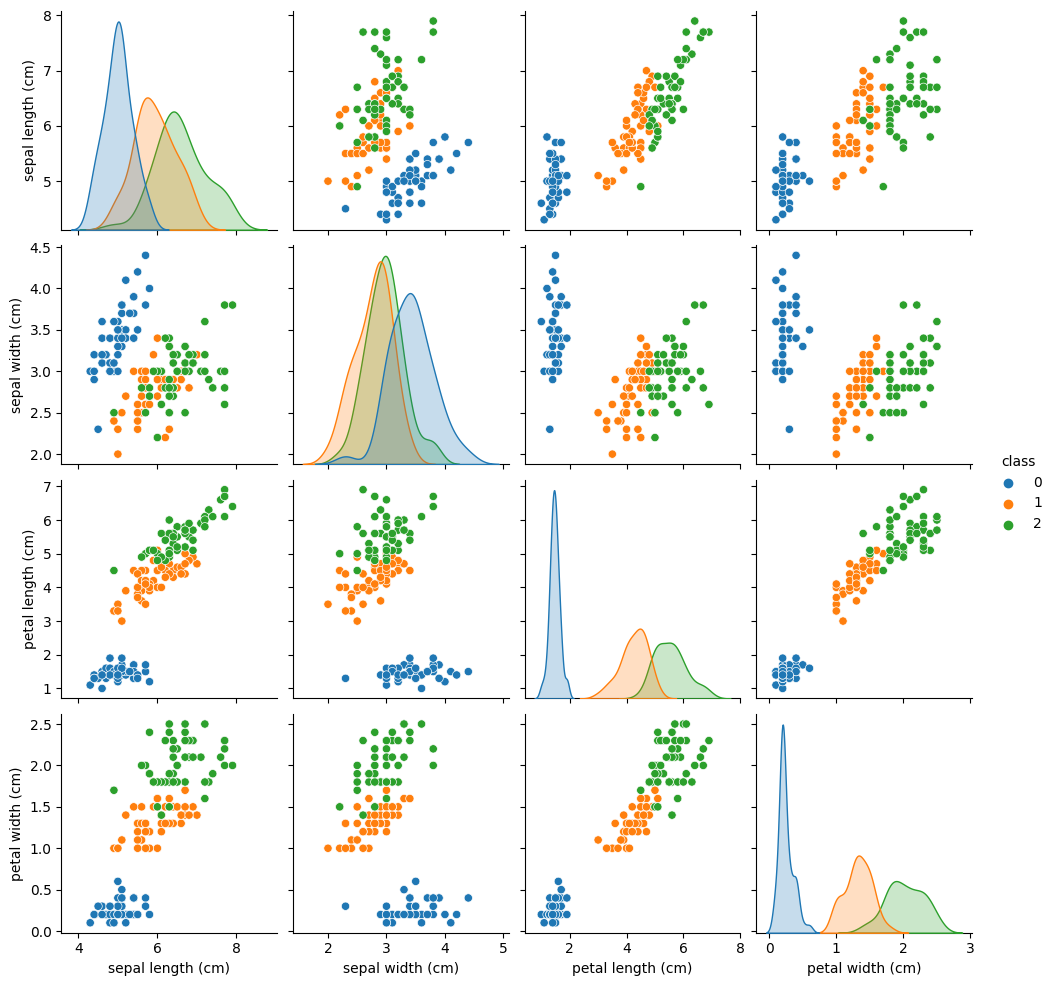

In [4]:
df = pd.DataFrame(iris_data.data, columns=iris_data.feature_names)
df["class"] = pd.Series(iris_data.target)

sns.pairplot(df, hue="class", palette="tab10")

<AxesSubplot: >

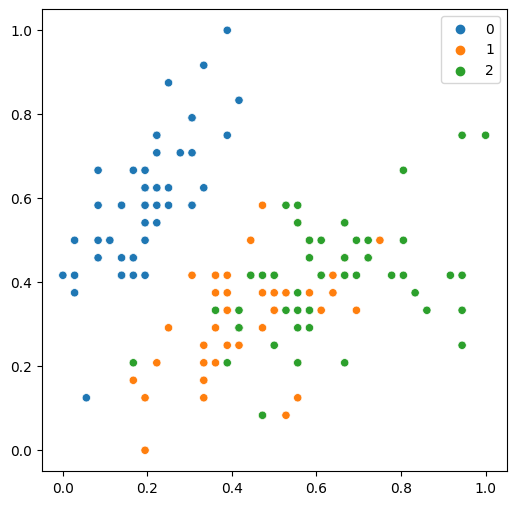

In [5]:
# Scale to range [0,1] 
from sklearn.preprocessing import MinMaxScaler
features = MinMaxScaler().fit_transform(features)

plt.rcParams["figure.figsize"] = (6, 6)
sns.scatterplot(x=features[:, 0], y=features[:, 1], hue=labels, palette="tab10")

In [6]:
algorithm_globals.random_seed=123 # fix the seed to ensure the results are reproducible.

#split the dataset into two parts: a training dataset and a test dataset
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

In [7]:
print(train_features[0], train_labels[0])
print(test_features[0], test_labels[0])

[0.86111111 0.33333333 0.86440678 0.75      ] 2
[0.55555556 0.20833333 0.66101695 0.58333333] 1


## Training a Classical SVM a.k.a. SVC for linear classifier

In [8]:
svc = SVC()
_ = svc.fit(train_features, train_labels)  # suppress printing the return value

train_score_c4 = svc.score(train_features, train_labels)
test_score_c4 = svc.score(test_features, test_labels)

print(f"Classical SVC on the training dataset: {train_score_c4:.2f}")
print(f"Classical SVC on the test dataset:     {test_score_c4:.2f}")

Classical SVC on the training dataset: 0.99
Classical SVC on the test dataset:     0.97


## Building and Training data on a Quantum Support Vector Machine 

This involves several steps
1. Data Encoding using Quantum Feature Maps
2. Building a Quantum Kernal
3. Connecting the Feature Map with Kernal for classification


## 1. Data Encoding

This is the process of taking classical data and encoding it to quantum state space using a quantum feature map.

### **Quantum Feature Maps**

A quantum feature map $\phi(\mathbf{x})$ is a map from the classical feature vector $\mathbf{x}$ to the quantum state $|\Phi(\mathbf{x})\rangle\langle\Phi(\mathbf{x})|$. This is faciliated by applying the unitary operation $\mathcal{U}_{\Phi(\mathbf{x})}$ on the initial state $|0\rangle^{n}$ where _n_ is the number of qubits being used for encoding.

The feature maps currently available in Qiskit ([`PauliFeatureMap`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.PauliFeatureMap.html), [`ZZFeatureMap`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZFeatureMap.html) and [`ZFeatureMap`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZZFeatureMap.html)) are those introduced in [_Havlicek et al_.  Nature **567**, 209-212 (2019)](https://www.nature.com/articles/s41586-019-0980-2), in particular the `ZZFeatureMap` is conjectured to be hard to simulate classically and can be implemented as short-depth circuits on near-term quantum devices.

**We will be using ZZFeatureMap for this model**

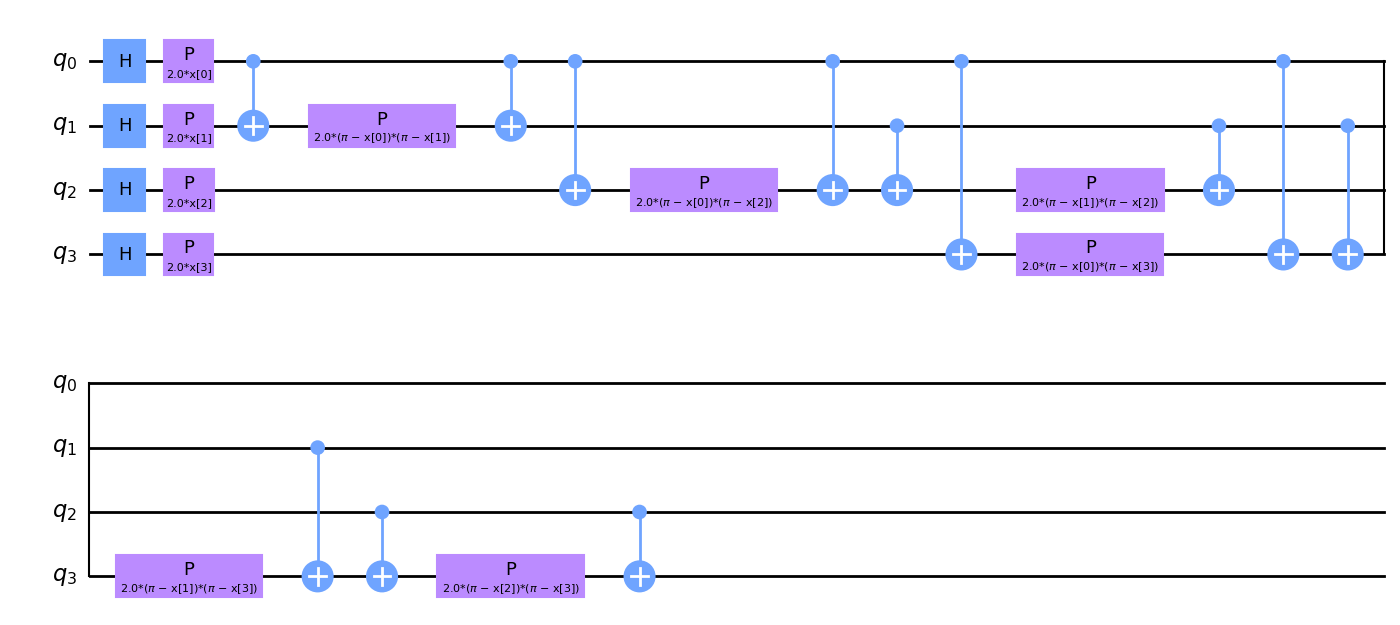

In [9]:
from qiskit.circuit.library import ZZFeatureMap

num_features = features.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output="mpl", fold=20)

Note: In the above feature map diagram, the parameters $x[0], x[1]$ are placeholders for input features

## 2. Quantum Kernal Estimation

A quantum feature map, $\phi(\mathbf{x})$, naturally gives rise to a quantum kernel, $k(\mathbf{x}_i,\mathbf{x}_j)= \phi(\mathbf{x}_j)^\dagger\phi(\mathbf{x}_i)$, which can be seen as a measure of similarity: $k(\mathbf{x}_i,\mathbf{x}_j)$ is large when $\mathbf{x}_i$ and $\mathbf{x}_j$ are close. 
​
When considering finite data, we can represent the quantum kernel as a matrix: 
$K_{ij} = \left| \langle \phi^\dagger(\mathbf{x}_j)| \phi(\mathbf{x}_i) \rangle \right|^{2}$. We can calculate each element of this kernel matrix on a quantum computer by calculating the transition amplitude:
$$
\left| \langle \phi^\dagger(\mathbf{x}_j)| \phi(\mathbf{x}_i) \rangle \right|^{2} = 
\left| \langle 0^{\otimes n} | \mathbf{U_\phi^\dagger}(\mathbf{x}_j) \mathbf{U_\phi}(\mathbf{x_i}) | 0^{\otimes n} \rangle \right|^{2}
$$
assuming the feature map is a parameterized quantum circuit, which can be described as a unitary transformation $\mathbf{U_\phi}(\mathbf{x})$ on $n$ qubits. 
​
This provides us with an estimate of the quantum kernel matrix, which we can then use in a kernel machine learning algorithm, such as support vector classification.

As discussed in [*Havlicek et al*.  Nature 567, 209-212 (2019)](https://www.nature.com/articles/s41586-019-0980-2), quantum kernel machine algorithms only have the potential of quantum advantage over classical approaches if the corresponding quantum kernel is hard to estimate classically. 

With our training and testing datasets ready, we set up the `QuantumKernel` class with the [ZZFeatureMap](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZZFeatureMap.html), and use the `BasicAer` `statevector_simulator` to estimate the training and testing kernel matrices.

In [10]:
zz_map = ZZFeatureMap(feature_dimension=4, reps=2, entanglement='linear', insert_barriers=True)
zz_kernel = QuantumKernel(feature_map=zz_map, quantum_instance=Aer.get_backend('statevector_simulator'))

Let's calculate the transition amplitude between the first and second training data samples, one of the entries in the training kernel matrix.

In [11]:
print(train_features[0])
print(test_features[1])

[0.86111111 0.33333333 0.86440678 0.75      ]
[0.69444444 0.41666667 0.76271186 0.83333333]


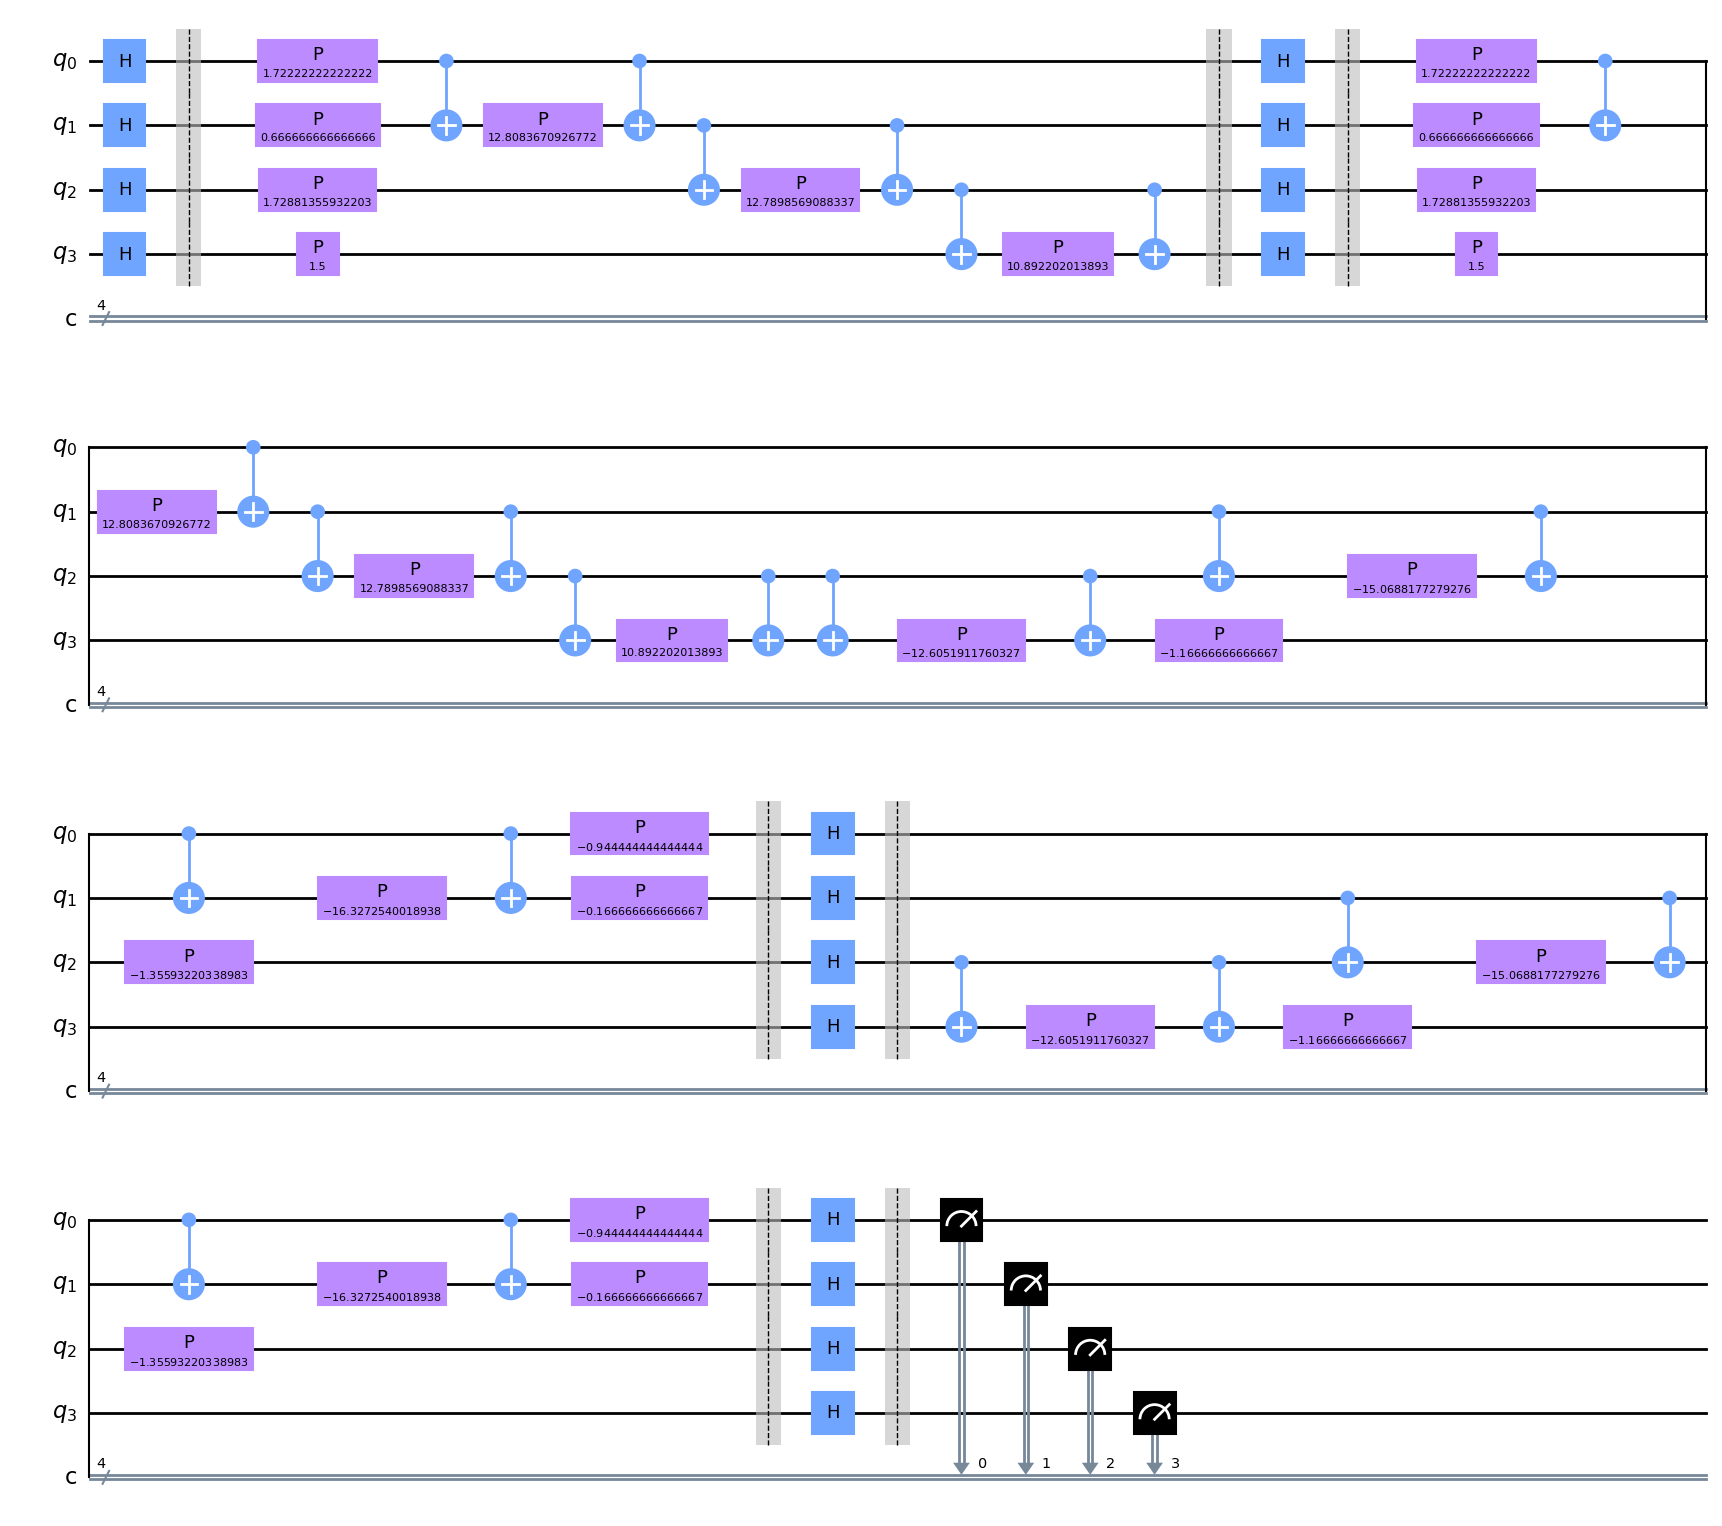

In [12]:
# First Create and draw the circuit
zz_circuit = zz_kernel.construct_circuit(train_features[0], train_features[1])
zz_circuit.decompose().decompose().draw(output='mpl')

The parameters in the gates are a little difficult to read, but notice how the circuit is symmetrical, with one half encoding one of the data samples, the other half encoding the other. 

We then simulate the circuit. We will use the `qasm_simulator` since the circuit contains measurements, but increase the number of shots to reduce the effect of sampling noise.


In [13]:
backend = Aer.get_backend('qasm_simulator')
job = execute(zz_circuit, backend, shots=8192, 
              seed_simulator=1024, seed_transpiler=1024)
counts = job.result().get_counts(zz_circuit)

The transition amplitude is the proportion of counts in the zero state:

In [14]:
counts['0000']/sum(counts.values())

0.3099365234375

This process is then repeated for each pair of training data samples to fill in the training kernel matrix, and between each training and testing data sample to fill in the testing kernel matrix. Note that each matrix is symmetric, so to reduce computation time, only half the entries are calculated explictly. 

Here we compute and plot the training and testing kernel matrices:

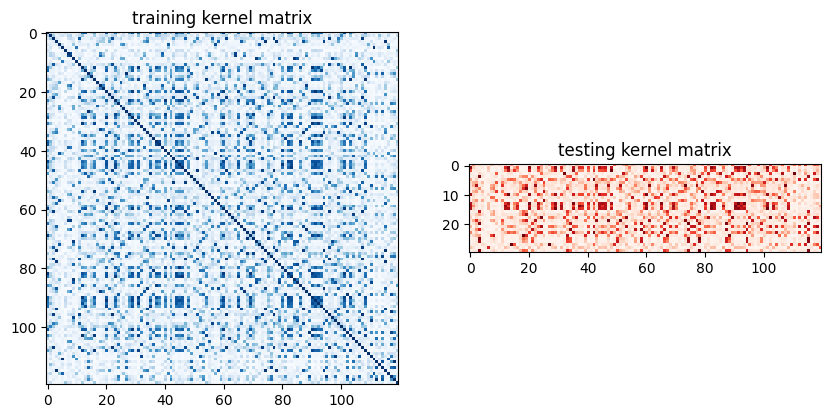

In [15]:
matrix_train = zz_kernel.evaluate(x_vec=train_features)
matrix_test = zz_kernel.evaluate(x_vec=test_features, y_vec=train_features)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(matrix_train),
              interpolation='nearest', origin='upper', cmap='Blues')
axs[0].set_title("training kernel matrix")
axs[1].imshow(np.asmatrix(matrix_test),
              interpolation='nearest', origin='upper', cmap='Reds')
axs[1].set_title("testing kernel matrix")
plt.show()

## 3. Quantum Support Vector Classification


Introduced in [*Havlicek et al*.  Nature 567, 209-212 (2019)](https://www.nature.com/articles/s41586-019-0980-2), the quantum kernel support vector classification algorithm consists of these steps:

<div><img src="attachment:qsvc.png" width="1200"></div> 

1. Build the train and test quantum kernel matrices.
    1. For each pair of datapoints in the training dataset $\mathbf{x}_{i},\mathbf{x}_j$, apply the feature map and measure the transition probability: $ K_{ij} = \left| \langle 0 | \mathbf{U}^\dagger_{\Phi(\mathbf{x_j})} \mathbf{U}_{\Phi(\mathbf{x_i})} | 0 \rangle \right|^2 $.
    2. For each training datapoint $\mathbf{x_i}$ and testing point $\mathbf{y_i}$, apply the feature map and measure the transition probability: $ K_{ij} = \left| \langle 0 | \mathbf{U}^\dagger_{\Phi(\mathbf{y_i})} \mathbf{U}_{\Phi(\mathbf{x_i})} | 0 \rangle \right|^2 $.
2. Use the train and test quantum kernel matrices in a classical support vector machine classification algorithm.

The `scikit-learn` `svc` algorithm allows us to define a [custom kernel](https://scikit-learn.org/stable/modules/svm.html#custom-kernels) in two ways: by providing the kernel as a callable function or by precomputing the kernel matrix. We can do either of these using the `QuantumKernel` class in Qiskit.

The following code takes the training and testing kernel matrices we calculated earlier and  provides them to the `scikit-learn` `svc` algorithm:

In [18]:
# zzpc_svc = SVC(kernel='precomputed')
# zzpc_svc.fit(matrix_train, train_labels)
# zzpc_score = zzpc_svc.score(matrix_test, train_labels)

# print(f'Precomputed kernel classification test score: {zzpc_score}')

In [17]:
zzcb_svc = SVC(kernel=zz_kernel.evaluate)
zzcb_svc.fit(train_features, train_labels)
zzcb_score = zzcb_svc.score(test_features, test_labels)

print(f'Callable kernel classification test score: {zzcb_score}')

Callable kernel classification test score: 0.9


Compare the quantum kernel with various classical kernels:

In [19]:
classical_kernels = ['linear', 'poly', 'rbf', 'sigmoid']

for kernel in classical_kernels:
    classical_svc = SVC(kernel=kernel)
    classical_svc.fit(train_features, train_labels)
    classical_score = classical_svc.score(test_features, test_labels)

    print('%s kernel classification test score:  %0.2f' % (kernel, classical_score))

linear kernel classification test score:  0.93
poly kernel classification test score:  0.93
rbf kernel classification test score:  0.97
sigmoid kernel classification test score:  0.47
